This Script is for: 1. General Explanation, 2. Qubit and Readout Resonator Spectroscopy and 3. Pulsed Qubit Control and Rabi Oscillations

1. General Explanation
What do I need for a SINGLE Qubit Measurement. Hardware: SHFQC, Software: LabOne Q


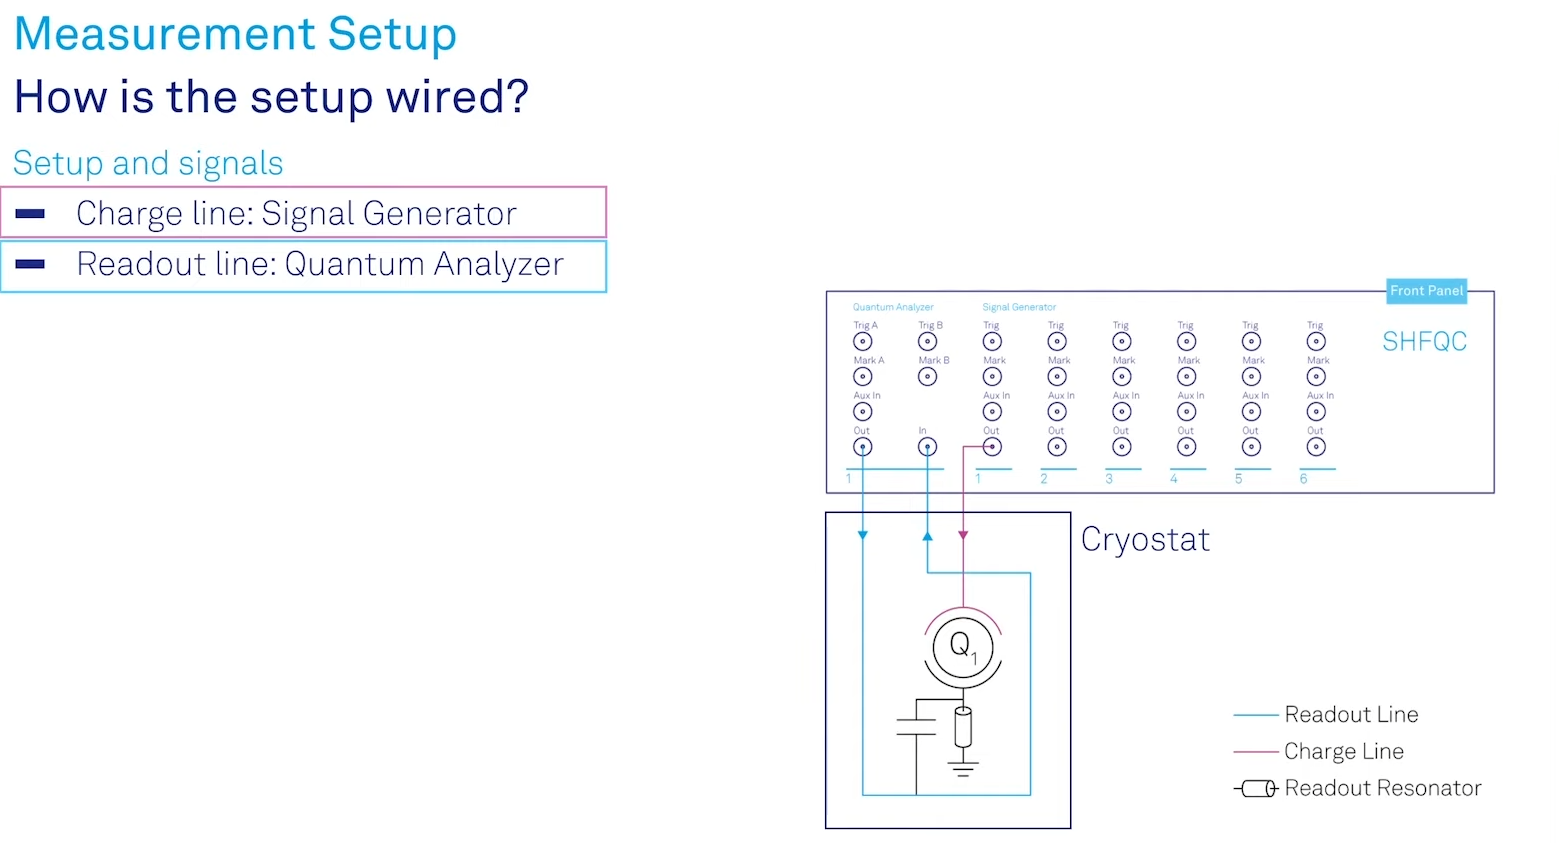

In [13]:
#Hardware Setup
from IPython.display import Image
Image(filename='ZI_Image1.png')

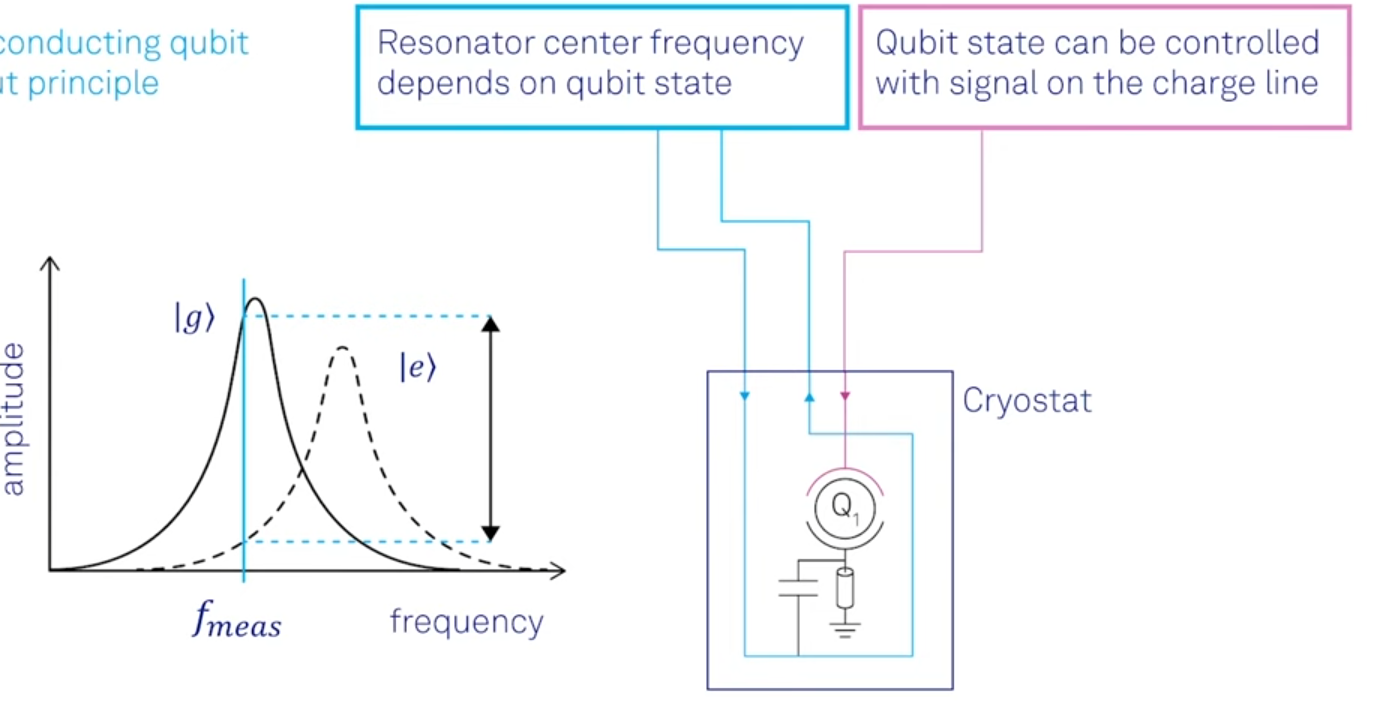

In [14]:
#Further Explanation Setup
from IPython.display import Image
Image(filename='ZI_Image2.png')

Explanation Spectroscopy
1. Resonator Spectroscopy
2. Qubit Spectroscopy

Resonator Spectroscopy:

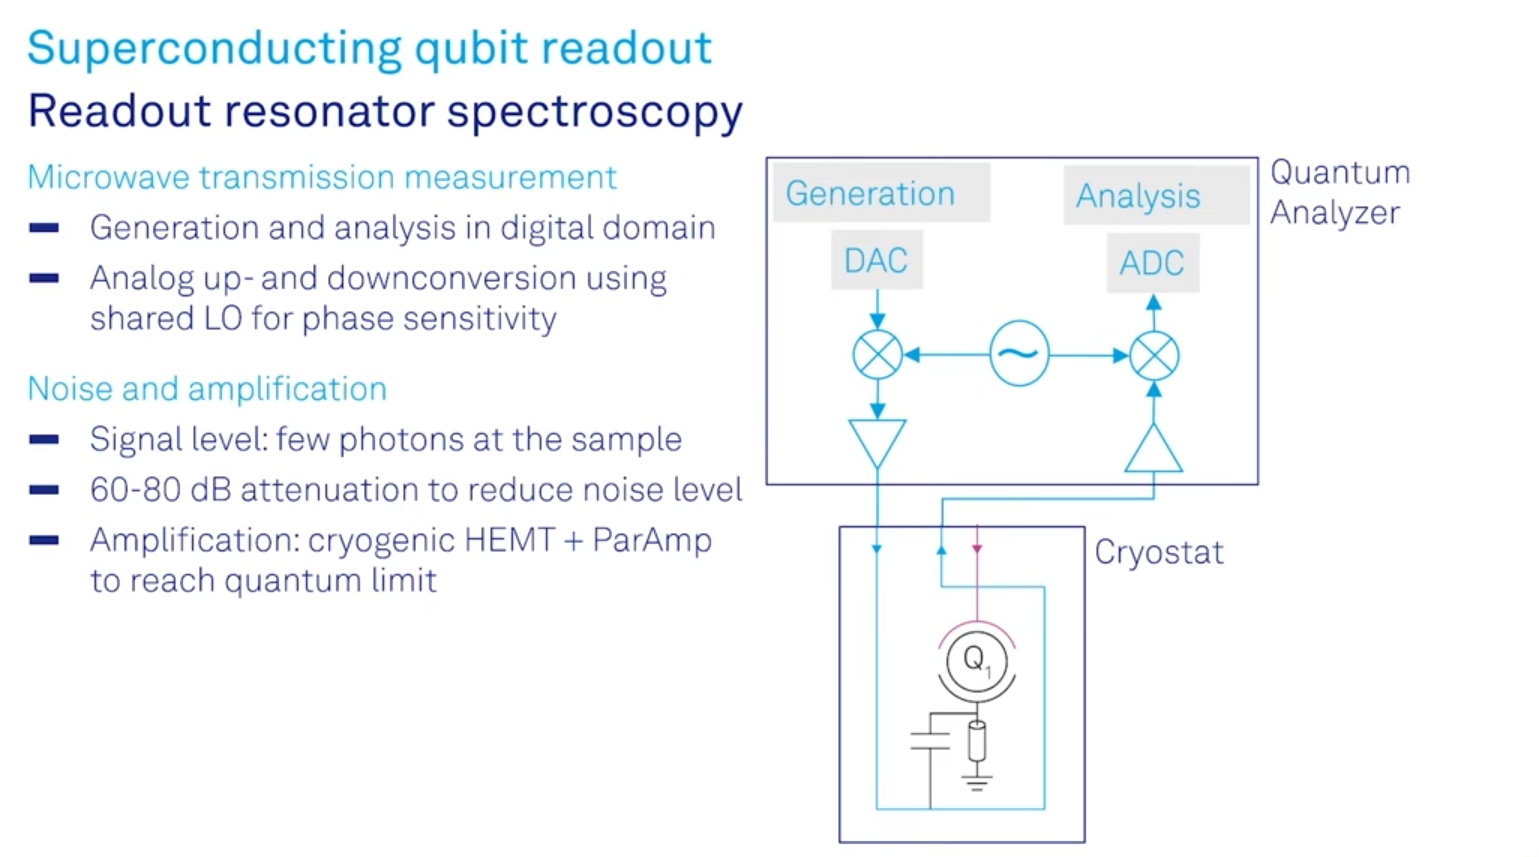

In [22]:
from IPython.display import Image
Image(filename='ZI_Image3.png')

2. Qubit Spectroscopy Setup

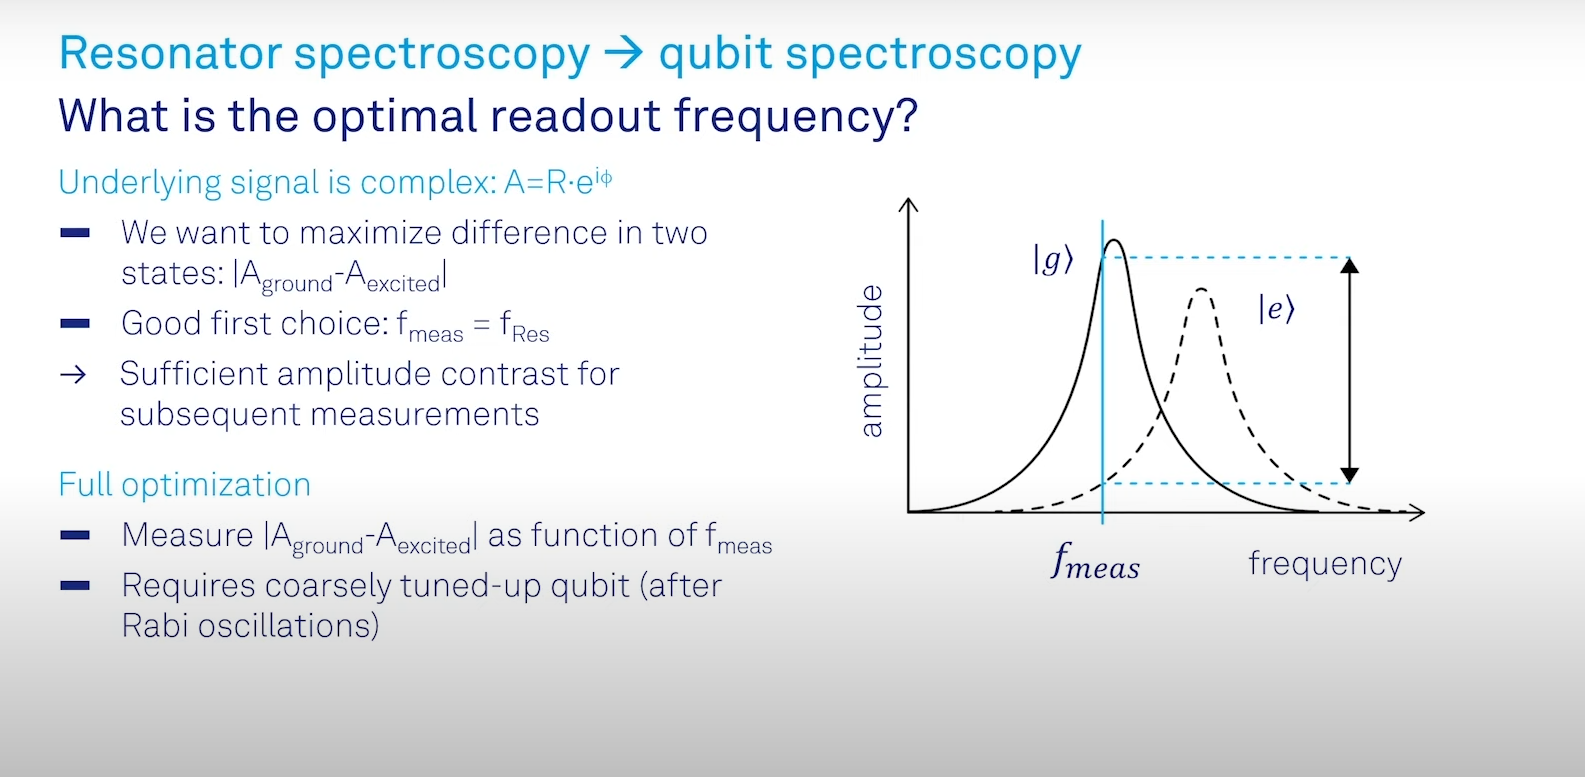

In [31]:
from IPython.display import Image
Image(filename='ZI_Image5.png')

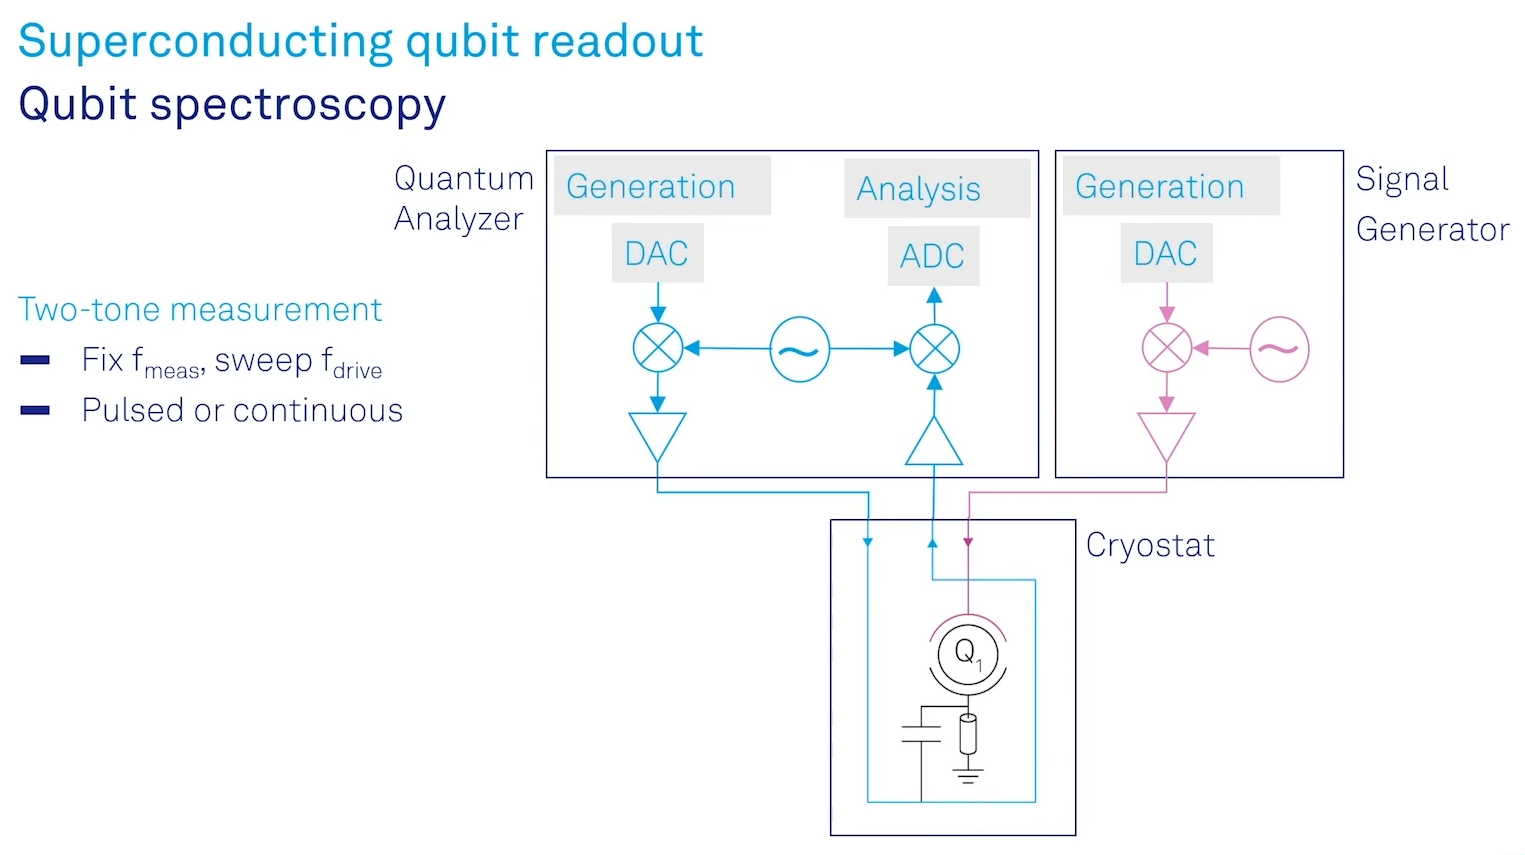

In [30]:
from IPython.display import Image
Image(filename='ZI_Image4.png')

Roles of Readout Power

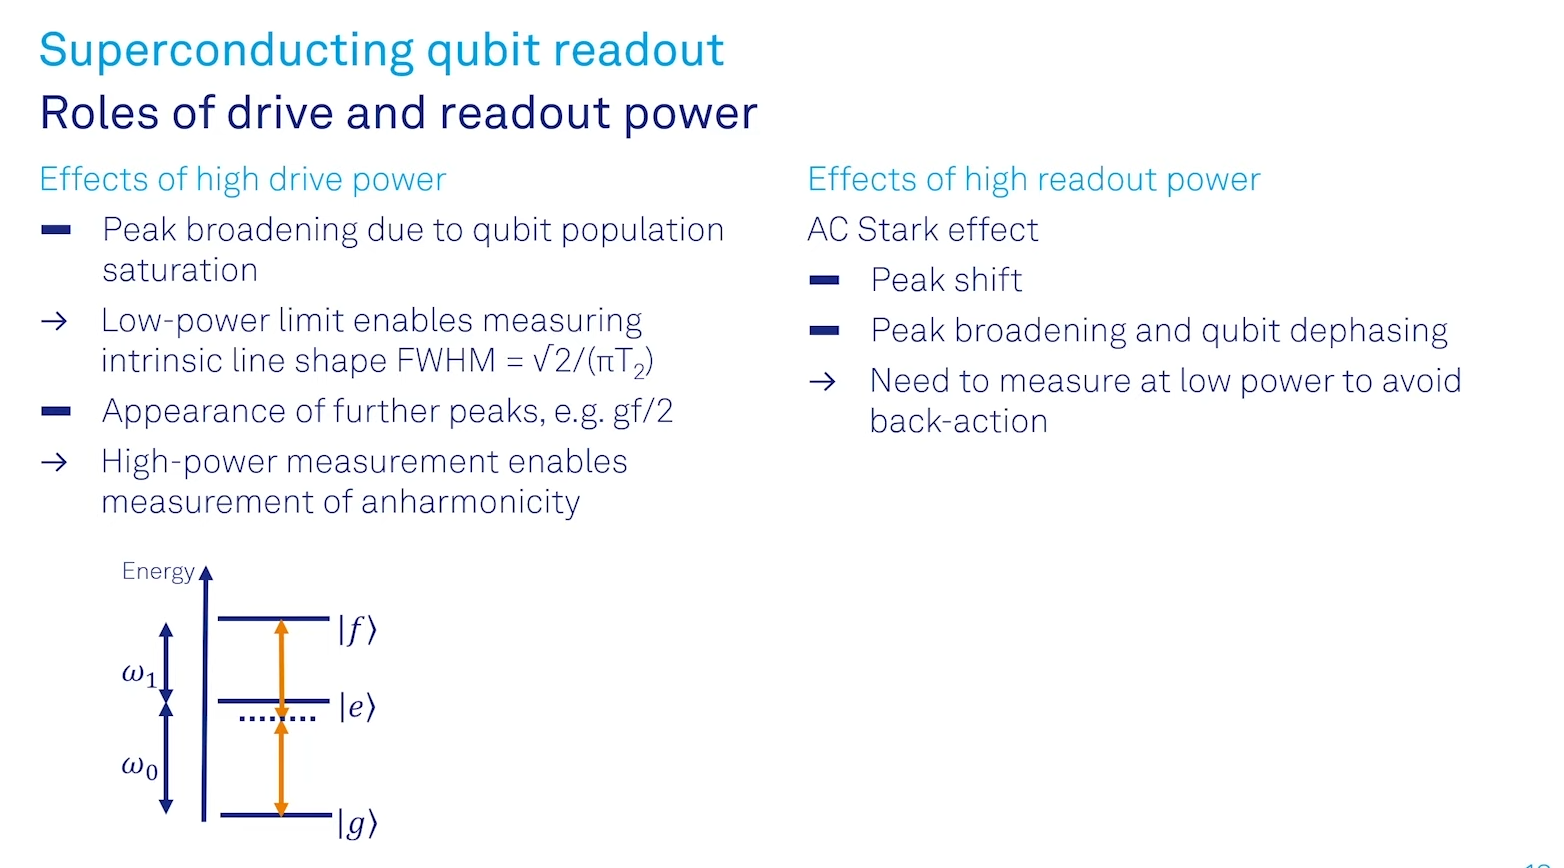

In [32]:
from IPython.display import Image
Image(filename='ZI_Image6.png')

In the following image you can see the Software Architecture for a bigger setup

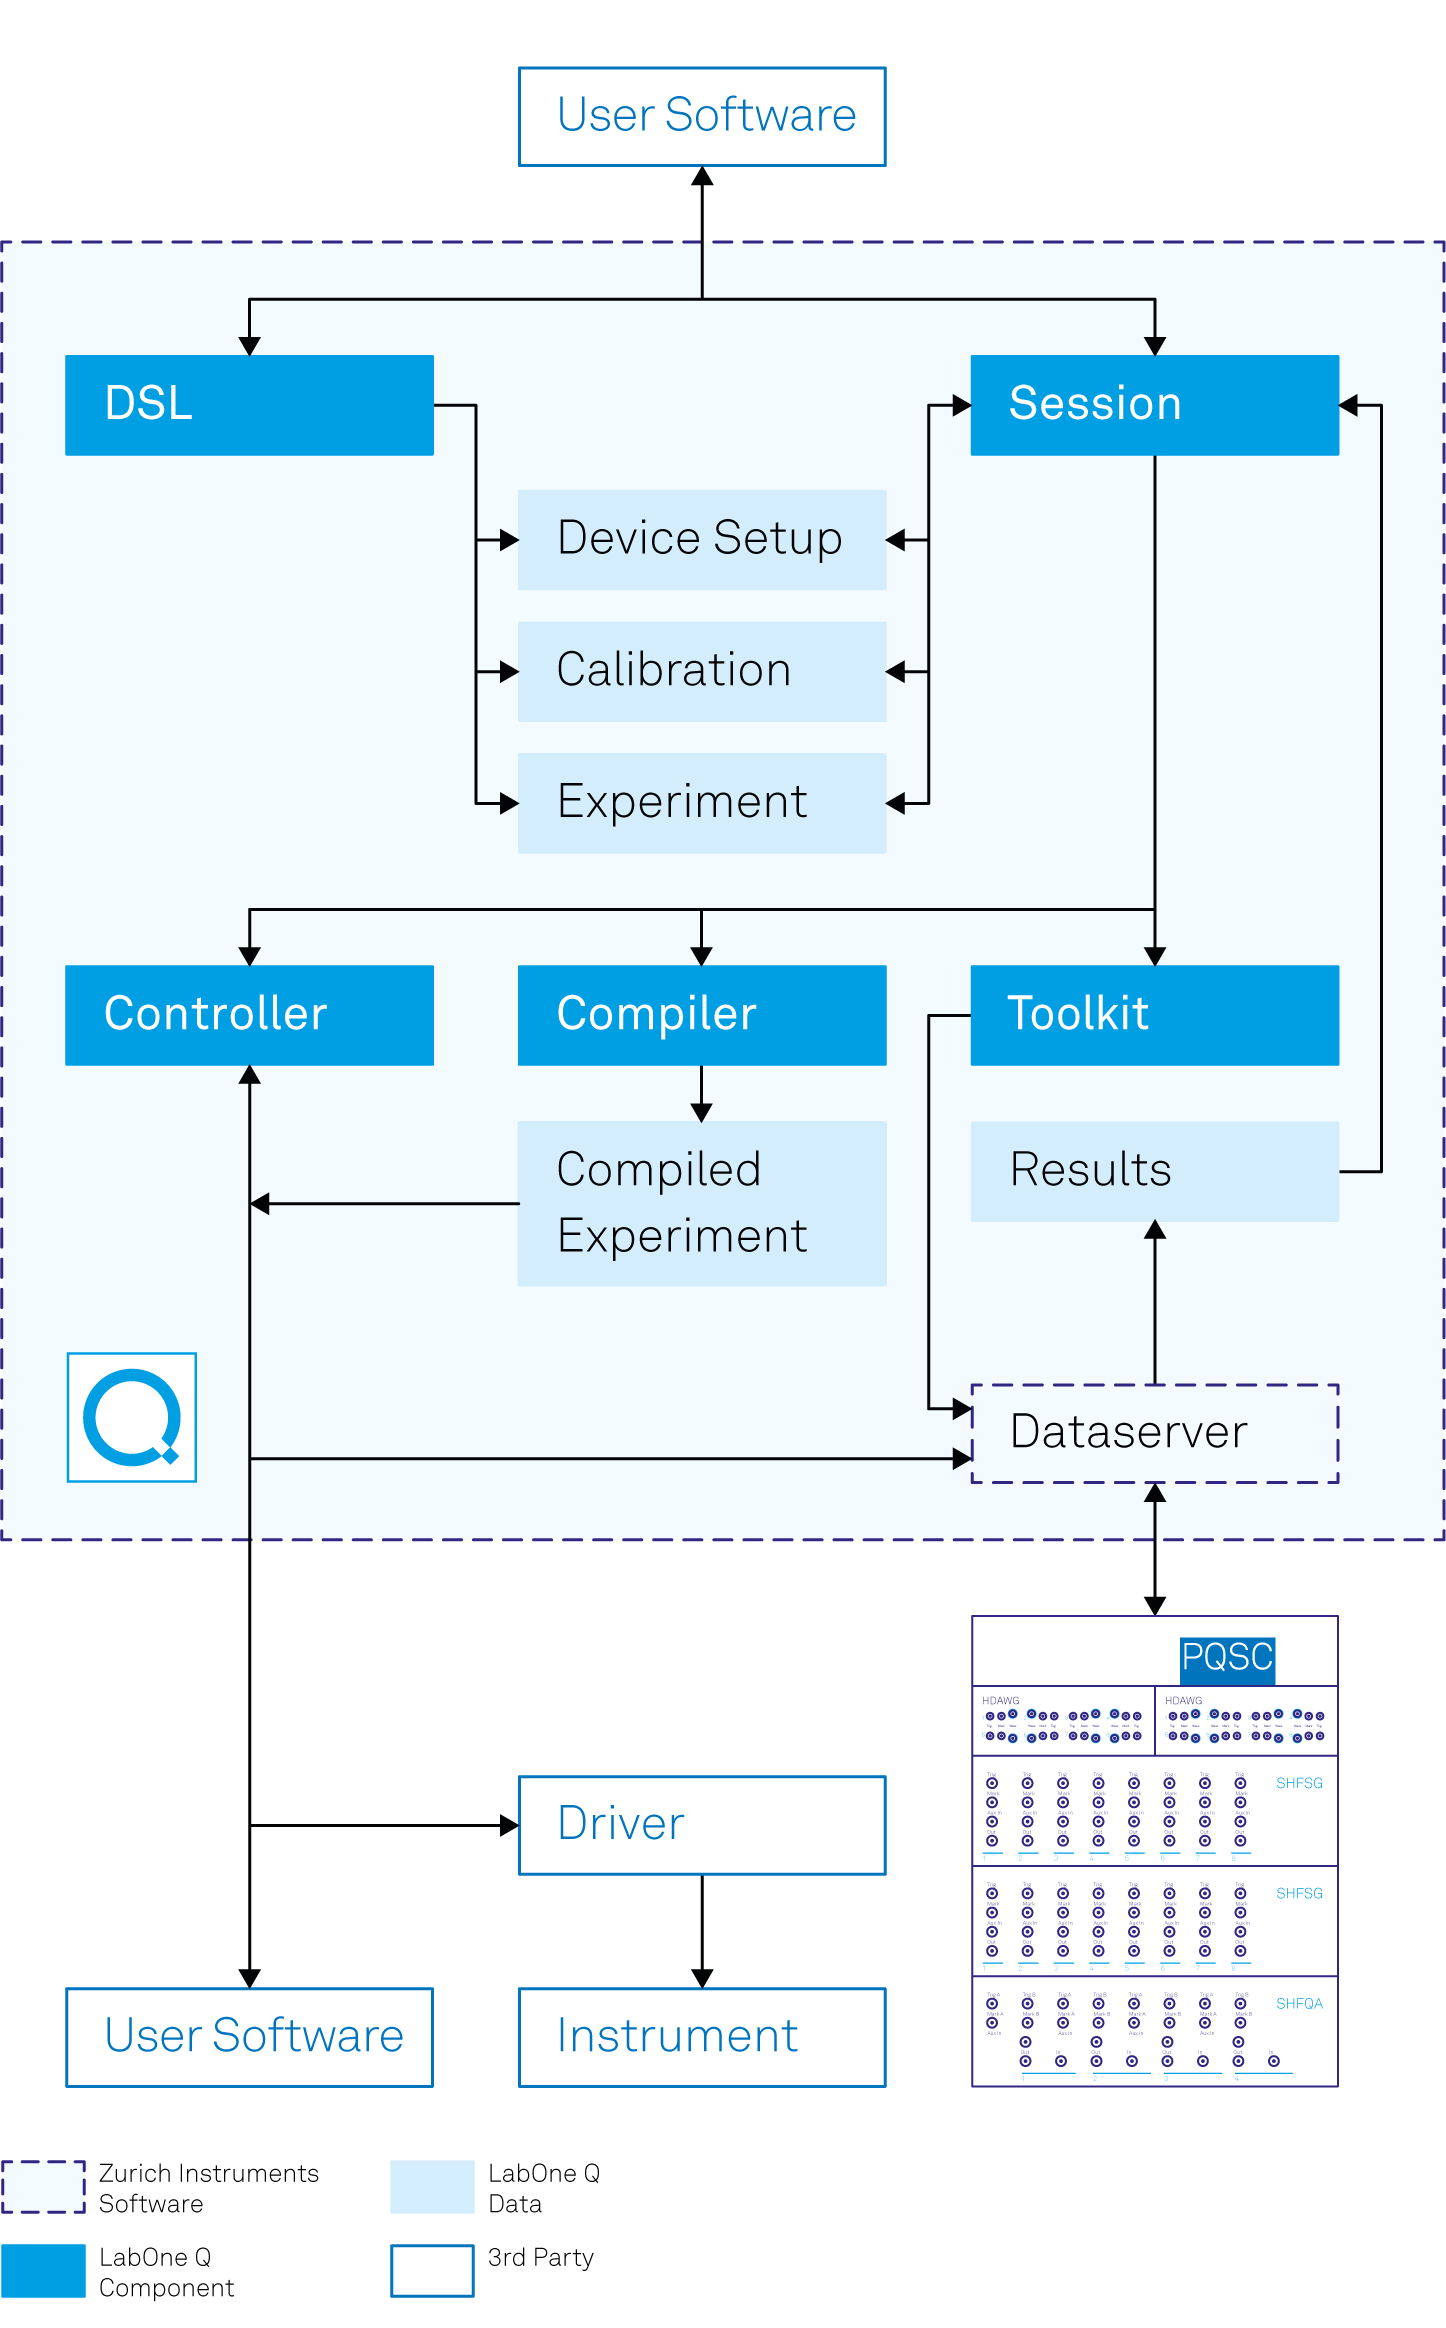

In [23]:
from IPython.display import Image
Image(filename='flowchart_QCCS.png')

The Code for reading out a single Qubit:

1. Setup

In [35]:
#Initial Imports
%config IPCompleter.greedy=True

# convenience import for all QCCS software functionality
from laboneq.simple import *

# helper import - needed to extract qubit and readout parameters from measurement data
from tuneup_helper import *

In [34]:
#DESCRITPTOR 
#Define initial PHYSICAL device setup
my_descriptor=f"""\
instrument_list:
  SHFQC:
  - address: DEV12XXX
    uid: device_shfqc
connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [26]:
# a collection of qubit control and readout parameters as a python dictionary
qubit_parameters = {
    'ro_freq' :  10e6,           # readout frequency of qubit 0 in [Hz] - relative to local oscillator for readout drive upconversion
    'ro_amp' : 0.5,              # readout amplitude
    'ro_amp_spec': 0.05,         # readout amplitude for spectroscopy
    'ro_len' : 1.0e-6,           # readout pulse length in [s]
    'ro_len_spec' : 1.0e-6,      # readout pulse length for resonator spectroscopy in [s]
    'ro_delay': 100e-9,          # readout delay after last drive signal in [s]
    'ro_int_delay' : 180e-9,     # readout line offset calibration - delay between readout pulse and start of signal acquisition in [s]
    
    'qb_freq': 20e6,             # qubit 0 drive frequency in [Hz] - relative to local oscillator for qubit drive upconversion
    'qb_amp_spec': 0.01,         # drive amplitude of qubit spectroscopy
    'qb_len_spec': 15e-6,        # drive pulse length for qubit spectroscopy in [s]
    'qb_len' : 4e-7,             # qubit drive pulse length in [s]
    'pi_amp' : 0.5,              # qubit drive amplitude for pi pulse
    'pi_half_amp' : 0.25,        # qubit drive amplitude for pi/2 pulse
    'qb_t1' : 100e-6,            # qubit T1 time
    'qb_t2' : 100e-6,            # qubit T2 time
    'relax' : 200e-6             # delay time after each measurement for qubit reset in [s]
}

# up / downconversion settings - to convert between IF and RF frequencies
lo_settings = {
    'qb_lo': 4.0e9,              # qubit LO frequency in [Hz]
    'ro_lo': 7.0e9               # readout LO frequency in [Hz]
}

In [27]:
qubit_parameters['ro_int_delay']= 350e-9

Setup Calibration

Generate a calibration object from the qubit control and readout parameters

In [28]:
# function that defines a setup calibration containing the qubit / readout parameters 
def define_calibration(parameters):

     # the calibration object will later be applied to the device setup
    my_calibration = Calibration()

    my_calibration["/logical_signal_groups/q0/drive_line"] = \
        SignalCalibration(
           # each logical signal can have an oscillator associated with it
            oscillator=Oscillator(
                frequency=parameters['qb_freq'],
                modulation_type=ModulationType.HARDWARE
            ),
            local_oscillator=Oscillator(
                frequency=lo_settings['qb_lo'],
            ),
            range=-30
        )
    
    # readout drive line
    my_calibration["/logical_signal_groups/q0/measure_line"] = \
         SignalCalibration(
            oscillator=Oscillator(
                frequency=parameters['ro_freq'],
                modulation_type=ModulationType.SOFTWARE
            ),
            port_delay=parameters['ro_delay'],
            local_oscillator=Oscillator(
                frequency=lo_settings['ro_lo'],
            ),
           range=-30
       )
    # acquisition line
    my_calibration["/logical_signal_groups/q0/acquire_line"] = \
         SignalCalibration(
            oscillator=Oscillator(
                frequency=parameters['ro_freq'],
                modulation_type=ModulationType.SOFTWARE
            ),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse 
            port_delay=parameters['ro_delay'] + parameters['ro_int_delay'],
            local_oscillator=Oscillator(
                frequency=lo_settings['ro_lo'],
            ),
            range=-30
        )
  
    return my_calibration

Create Device Setup and Apply Calibration Data, Connect to the Instruments

The Device Setup

Create the device setup from the descriptor and apply to qubit control and readout calibration to it

In [29]:
# define the DeviceSetup from descriptor - additionally include information on the dataserver used to connect to the instruments 
my_setup = DeviceSetup.from_descriptor(
    my_descriptor,
    server_host="localhost",
    server_port="8004",
    setup_name="psi",
) 

# define Calibration object based on qubit control and readout parameters
my_calibration = define_calibration(parameters=qubit_parameters)
# apply calibration to device setup
my_setup.set_calibration(my_calibration)

Create and Connect to a QCCS Session

Establishes the connection to the instruments and readies them for experiments
QCCS monitor is a software to monitor all the devices in one. It can be started as follows:
LabOne needs to run, be connected to the server and then 